In [2]:
import findspark
findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("BusBreakdowns").getOrCreate()

# Read the file 
file = "Bus_Breakdown_and_Delays.csv.gz"
df = spark.read.option("header", "true").csv(file)

In [2]:
df.printSchema()

root
 |-- School_Year: string (nullable = true)
 |-- Busbreakdown_ID: string (nullable = true)
 |-- Run_Type: string (nullable = true)
 |-- Bus_No: string (nullable = true)
 |-- Route_Number: string (nullable = true)
 |-- Reason: string (nullable = true)
 |-- Schools_Serviced: string (nullable = true)
 |-- Occurred_On: string (nullable = true)
 |-- Created_On: string (nullable = true)
 |-- Boro: string (nullable = true)
 |-- Bus_Company_Name: string (nullable = true)
 |-- How_Long_Delayed: string (nullable = true)
 |-- Number_Of_Students_On_The_Bus: string (nullable = true)
 |-- Has_Contractor_Notified_Schools: string (nullable = true)
 |-- Has_Contractor_Notified_Parents: string (nullable = true)
 |-- Have_You_Alerted_OPT: string (nullable = true)
 |-- Informed_On: string (nullable = true)
 |-- Incident_Number: string (nullable = true)
 |-- Last_Updated_On: string (nullable = true)
 |-- Breakdown_or_Running_Late: string (nullable = true)
 |-- School_Age_or_PreK: string (nullable = tru

In [3]:
df.head(2)

[Row(School_Year='2018-2019', Busbreakdown_ID='1456627', Run_Type='General Ed AM Run', Bus_No='1141', Route_Number='R1086', Reason='Heavy Traffic', Schools_Serviced='31051', Occurred_On='09/05/2018 07:28:00 AM', Created_On='09/05/2018 07:29:00 AM', Boro='Staten Island', Bus_Company_Name='PIONEER TRANSPORTATION CORP', How_Long_Delayed='31-45 Min', Number_Of_Students_On_The_Bus='0', Has_Contractor_Notified_Schools='Yes', Has_Contractor_Notified_Parents='No', Have_You_Alerted_OPT='No', Informed_On='09/05/2018 07:29:00 AM', Incident_Number=None, Last_Updated_On='01/01/1900 12:00:00 AM', Breakdown_or_Running_Late='Running Late', School_Age_or_PreK='School-Age'),
 Row(School_Year='2018-2019', Busbreakdown_ID='1456628', Run_Type='Special Ed AM Run', Bus_No='87D', Route_Number='X966', Reason='Mechanical Problem', Schools_Serviced='12,006,120,091,213,400,000', Occurred_On='09/05/2018 07:10:00 AM', Created_On='09/05/2018 07:29:00 AM', Boro='Bronx', Bus_Company_Name='LITTLE LISA BUS CO. INC.', Ho

In [3]:
# add various groups of columns
colname_ID = ['Busbreakdown_ID','Bus_No', 'Route_Number','Schools_Serviced','Incident_Number']
colname_category = ['School_Year', 'Run_Type',  'Reason',   'Boro', 'Bus_Company_Name']
colname_time = ['Occurred_On', 'Created_On', 'Informed_On', 'Last_Updated_On']
colname_num = ['Number_Of_Students_On_The_Bus']
colname_flag = ['Has_Contractor_Notified_Schools', 'Has_Contractor_Notified_Parents', 'Have_You_Alerted_OPT', 'Breakdown_or_Running_Late', 'School_Age_or_PreK']
colname_target = ['How_Long_Delayed']
delay_time_category = ['16-30 Min', '31-45 Min', '0-15 Min', '46-60 Min', '61-90 Min']

In [4]:
# Import the relevant Python libraries (some for visualisation)
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql import functions as F
from pyspark.sql.functions import mean
from pyspark.sql.functions import isnan, when, count, col

+----------------+------+
|How_Long_Delayed| Count|
+----------------+------+
|        0-15 Min| 34957|
|       16-30 Min| 95136|
|       31-45 Min|106841|
|       46-60 Min| 64785|
|       61-90 Min| 33057|
+----------------+------+



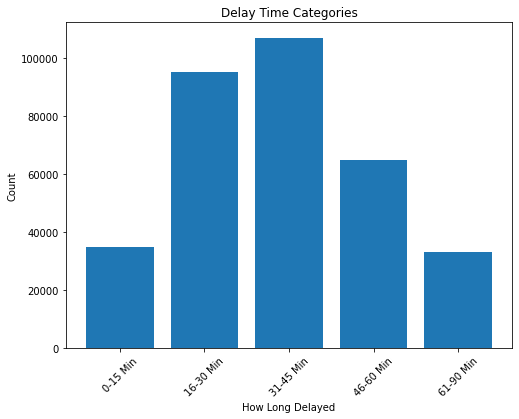

In [6]:
# Explore target column
filtered_df = df.filter(df['How_Long_Delayed'].isin(delay_time_category))
category_counts = filtered_df.groupBy('How_Long_Delayed').agg(F.count('*').alias('Count'))
category_counts.show()

category_counts_pandas = category_counts.toPandas()
# Plot
plt.figure(figsize=(8, 6))
plt.bar(category_counts_pandas['How_Long_Delayed'], category_counts_pandas['Count'])
plt.xlabel('How Long Delayed')
plt.ylabel('Count')
plt.title('Delay Time Categories')
plt.xticks(rotation=45)
plt.show()

+----------------+---+---+---+---+------+---+---+---+---+------------+
|   Mean_Students|10%|20%|30%|40%|Median|60%|70%|80%|90%|Max_Students|
+----------------+---+---+---+---+------+---+---+---+---+------------+
|3.13555631228045|0.0|0.0|0.0|0.0|   0.0|0.0|2.0|4.0|6.0|        9658|
+----------------+---+---+---+---+------+---+---+---+---+------------+



+------------------+---+---+---+---+------+---+---+---+---+------------+
|     Mean_Students|10%|20%|30%|40%|Median|60%|70%|80%|90%|Max_Students|
+------------------+---+---+---+---+------+---+---+---+---+------------+
|1.8388492734738768|0.0|0.0|0.0|0.0|   0.0|0.0|2.0|4.0|6.0|           9|
+------------------+---+---+---+---+------+---+---+---+---+------------+



+----------------+------------------+
|How_Long_Delayed|     Mean_Students|
+----------------+------------------+
|        0-15 Min| 2.960302241048685|
|       16-30 Min| 3.009232192803516|
|       31-45 Min|1.1698180353814889|
|       46-60 Min|0.7909749355242228|
|       61-90 Min|1.4998940453485907|
+----------------+------------------+



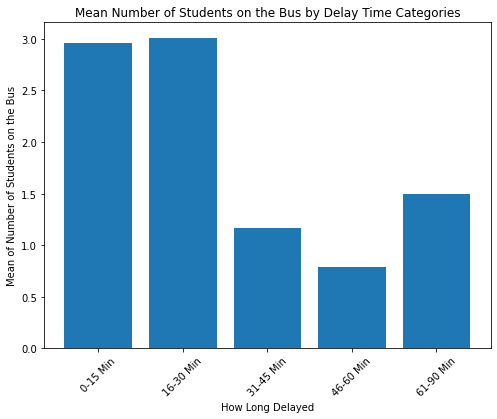

In [7]:
# Explore the numeric column
filtered_df = df.filter(df['How_Long_Delayed'].isin(delay_time_category))
statistics_df = filtered_df.agg(
    F.mean('Number_Of_Students_On_The_Bus').alias('Mean_Students'),
    F.expr('percentile_approx(Number_Of_Students_On_The_Bus, 0.1)').alias('10%'),
    F.expr('percentile_approx(Number_Of_Students_On_The_Bus, 0.2)').alias('20%'),
    F.expr('percentile_approx(Number_Of_Students_On_The_Bus, 0.3)').alias('30%'),
    F.expr('percentile_approx(Number_Of_Students_On_The_Bus, 0.4)').alias('40%'),
    F.expr('percentile_approx(Number_Of_Students_On_The_Bus, 0.5)').alias('Median'),
    F.expr('percentile_approx(Number_Of_Students_On_The_Bus, 0.6)').alias('60%'),
    F.expr('percentile_approx(Number_Of_Students_On_The_Bus, 0.7)').alias('70%'),
    F.expr('percentile_approx(Number_Of_Students_On_The_Bus, 0.8)').alias('80%'),
    F.expr('percentile_approx(Number_Of_Students_On_The_Bus, 0.9)').alias('90%'),
    F.max('Number_Of_Students_On_The_Bus').alias('Max_Students')
)
statistics_df.show()

# Filter
filtered_df = df.filter(df['How_Long_Delayed'].isin(delay_time_category) & (df['Number_Of_Students_On_The_Bus'] < 100))
statistics_df = filtered_df.agg(
    F.mean('Number_Of_Students_On_The_Bus').alias('Mean_Students'),
    F.expr('percentile_approx(Number_Of_Students_On_The_Bus, 0.1)').alias('10%'),
    F.expr('percentile_approx(Number_Of_Students_On_The_Bus, 0.2)').alias('20%'),
    F.expr('percentile_approx(Number_Of_Students_On_The_Bus, 0.3)').alias('30%'),
    F.expr('percentile_approx(Number_Of_Students_On_The_Bus, 0.4)').alias('40%'),
    F.expr('percentile_approx(Number_Of_Students_On_The_Bus, 0.5)').alias('Median'),
    F.expr('percentile_approx(Number_Of_Students_On_The_Bus, 0.6)').alias('60%'),
    F.expr('percentile_approx(Number_Of_Students_On_The_Bus, 0.7)').alias('70%'),
    F.expr('percentile_approx(Number_Of_Students_On_The_Bus, 0.8)').alias('80%'),
    F.expr('percentile_approx(Number_Of_Students_On_The_Bus, 0.9)').alias('90%'),
    F.max('Number_Of_Students_On_The_Bus').alias('Max_Students')
)
statistics_df.show()


# Group by delay
mean_students_per_category = filtered_df.groupBy('How_Long_Delayed').agg(mean('Number_Of_Students_On_The_Bus').alias('Mean_Students'))
mean_students_per_category.show()

# Plot
mean_students_per_category_pandas = mean_students_per_category.toPandas()
plt.figure(figsize=(8, 6))
plt.bar(mean_students_per_category_pandas['How_Long_Delayed'], mean_students_per_category_pandas['Mean_Students'])
plt.xlabel('How Long Delayed')
plt.ylabel('Mean of Number of Students on the Bus')
plt.title('Mean Number of Students on the Bus by Delay Time Categories')
plt.xticks(rotation=45)
plt.show()

+-----------+------+
|School_Year| count|
+-----------+------+
|  2018-2019|109059|
|  2022-2023| 94651|
|  2021-2022| 70179|
|  2019-2020| 65998|
|  2020-2021| 20438|
+-----------+------+



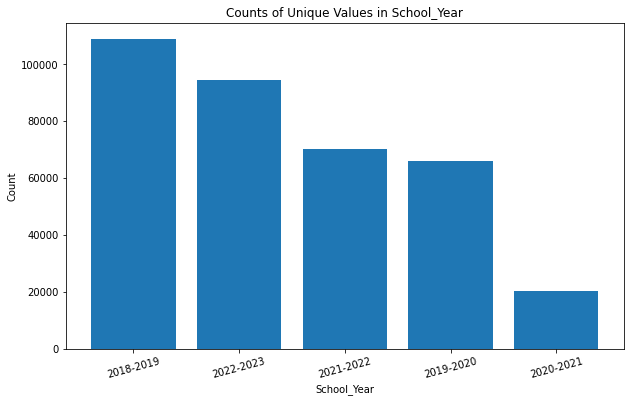

+--------------------+------+
|            Run_Type| count|
+--------------------+------+
|   Special Ed AM Run|213180|
|   Special Ed PM Run| 55823|
|   General Ed AM Run| 40320|
|            Pre-K/EI| 36609|
|   General Ed PM Run| 12202|
|General Ed Field ...|  1048|
|Special Ed Field ...|   800|
| Project Read PM Run|   280|
| Project Read AM Run|    55|
|Project Read Fiel...|     3|
+--------------------+------+



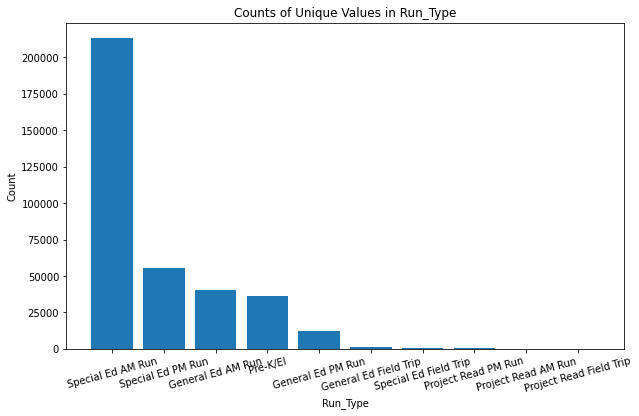

+--------------------+------+
|              Reason| count|
+--------------------+------+
|       Heavy Traffic|229766|
|               Other| 59312|
|  Mechanical Problem| 31962|
|         Problem Run| 10524|
|         Won`t Start|  7794|
|           Flat Tire|  7022|
|  Weather Conditions|  4888|
|Late return from ...|  3813|
|            Accident|  3121|
|   Delayed by School|  2123|
+--------------------+------+



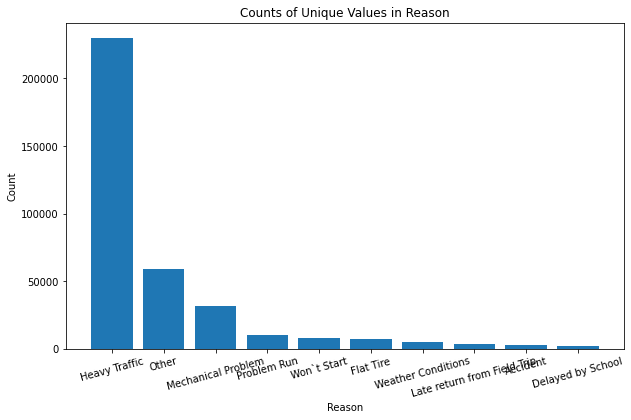

+---------------+-----+
|           Boro|count|
+---------------+-----+
|      Manhattan|95203|
|       Brooklyn|83712|
|          Bronx|82417|
|         Queens|56932|
|  Staten Island|17839|
|  Nassau County|14637|
|    Westchester| 6138|
|     New Jersey| 1347|
|   All Boroughs| 1198|
|Rockland County|  587|
|    Connecticut|  233|
+---------------+-----+



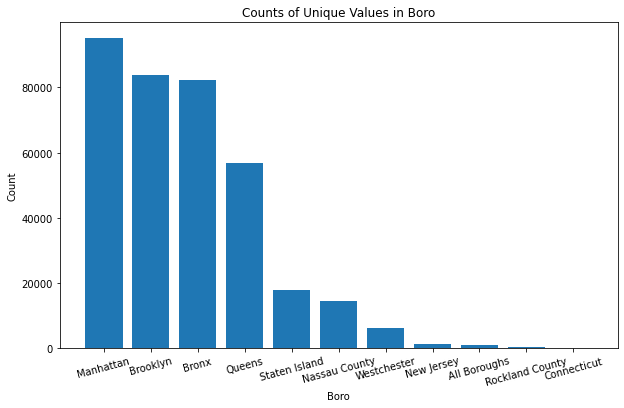

+--------------------+-----+
|    Bus_Company_Name|count|
+--------------------+-----+
|LEESEL TRANSPORTA...|70327|
|PIONEER TRANSPORT...|29709|
|RELIANT TRANSPORT...|20728|
|PRIDE TRANSPORTAT...|20102|
|  BORO TRANSIT, INC.|19020|
|HOYT TRANSPORTATI...|15324|
|VAN TRANS LLC (B2...|13121|
|NYC SCHOOL BUS UM...|12711|
|        G.V.C., LTD.|12213|
|ALLIED TRANSIT CORP.|11916|
|EMPIRE CHARTER SE...|11694|
|     L & M BUS CORP.|10012|
|LITTLE RICHIE BUS...| 9364|
|         SNT BUS INC| 8250|
|  L & M BUS CORP (A)| 7089|
|EMPIRE STATE BUS ...| 5896|
|LOGAN BUS COMPANY...| 5742|
|SELBY TRANSPORTATION| 5523|
| G.V.C. LTD. (B2192)| 5218|
|LORINDA ENTERPRIS...| 4983|
+--------------------+-----+
only showing top 20 rows



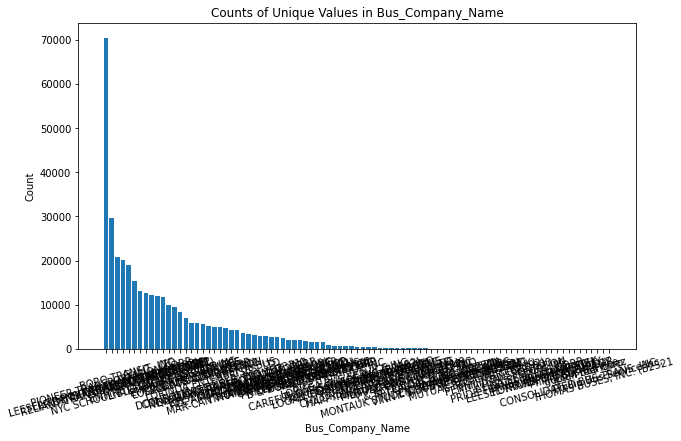

In [7]:
# explore categorical columns
for item in colname_category:
    # Filter out rows with None values 
    filtered_df = df.filter(df[item].isNotNull())
    
    category_counts = filtered_df.groupBy(item).count().orderBy('count', ascending=False)
    category_counts.show()

    category_counts_pd = category_counts.toPandas()
    if not category_counts_pd.empty:
        plt.figure(figsize=(10, 6))
        plt.bar(category_counts_pd[item], category_counts_pd['count'])
        plt.xlabel(item)
        plt.ylabel('Count')
        plt.title(f'Counts of Unique Values in {item}')
        plt.xticks(rotation=15)
        plt.show()

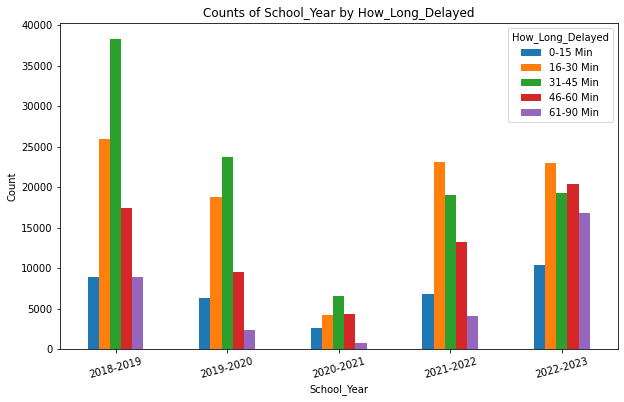

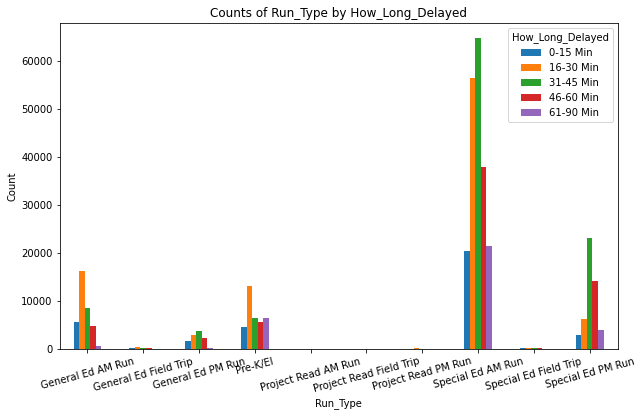

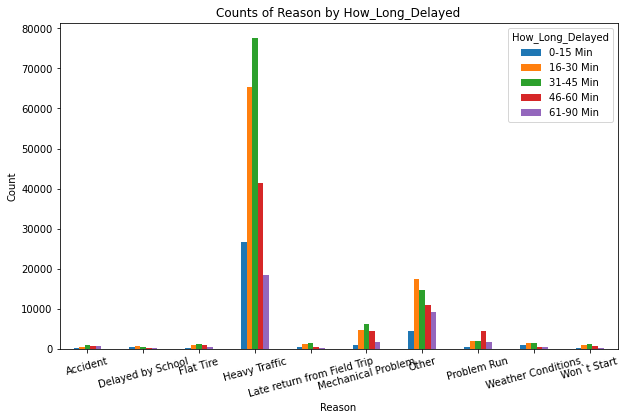

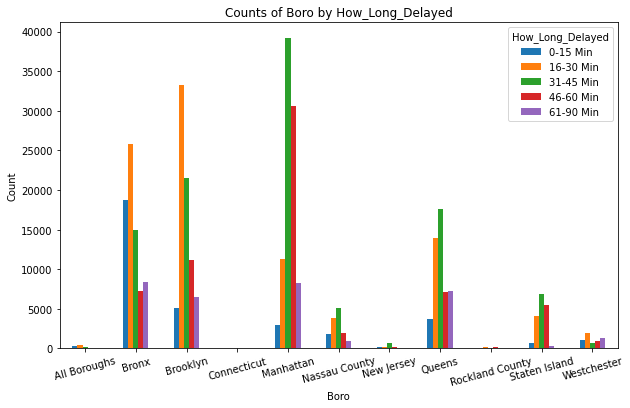

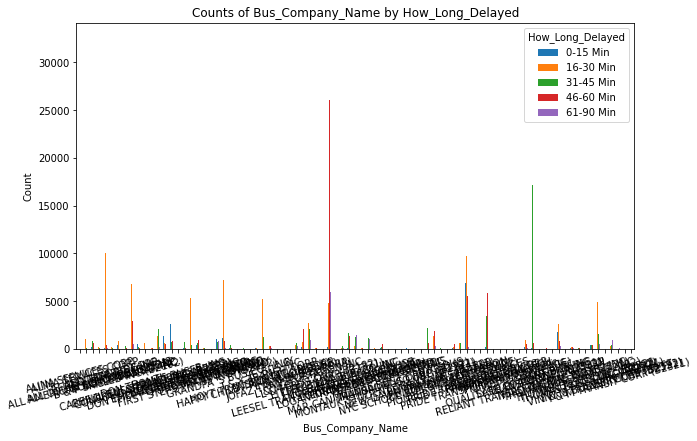

In [5]:
# explore categorical columns by group
for item in colname_category:
    # Filter out rows with None values 
    filtered_df = df.filter(df[item].isNotNull())
    
    filtered_df = filtered_df.filter(filtered_df['How_Long_Delayed'].isin(delay_time_category))
    category_counts = filtered_df.groupBy(item, 'How_Long_Delayed').count().orderBy('How_Long_Delayed')
    category_counts_pd = category_counts.toPandas()

    if not category_counts_pd.empty:
        pivot_df = category_counts_pd.pivot(index=item, columns='How_Long_Delayed', values='count')
        pivot_df.plot(kind='bar', figsize=(10, 6))
        plt.ylabel('Count')
        plt.xlabel(item)
        plt.xticks(rotation=15)
        plt.title(f'Counts of {item} by How_Long_Delayed')
        plt.show()

+-------------------------------+------+
|Has_Contractor_Notified_Schools| count|
+-------------------------------+------+
|                             No| 67643|
|                            Yes|267133|
+-------------------------------+------+



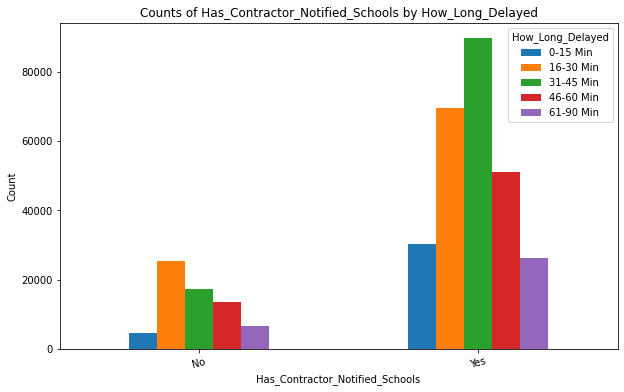

+-------------------------------+------+
|Has_Contractor_Notified_Parents| count|
+-------------------------------+------+
|                             No| 98128|
|                            Yes|236648|
+-------------------------------+------+



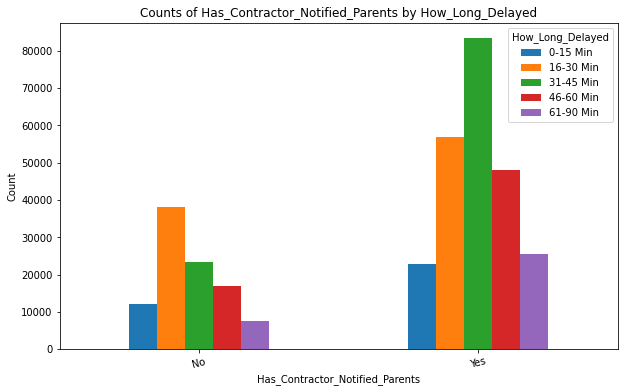

+--------------------+------+
|Have_You_Alerted_OPT| count|
+--------------------+------+
|                  No|268011|
|                 Yes| 66765|
+--------------------+------+



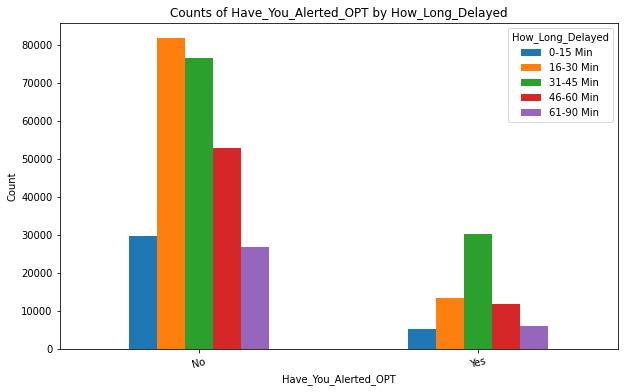

+-------------------------+------+
|Breakdown_or_Running_Late| count|
+-------------------------+------+
|             Running Late|334776|
+-------------------------+------+



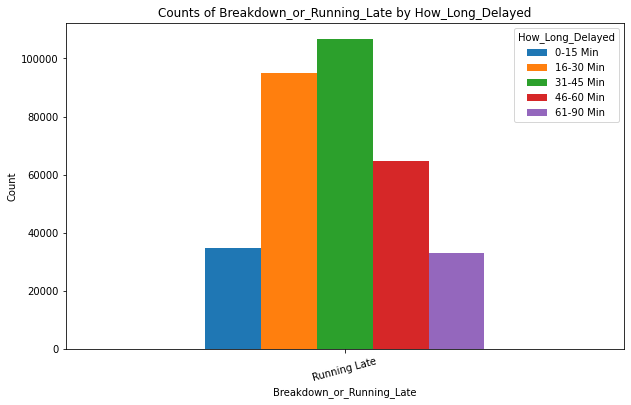

+------------------+------+
|School_Age_or_PreK| count|
+------------------+------+
|        School-Age|298727|
|             Pre-K| 36049|
+------------------+------+



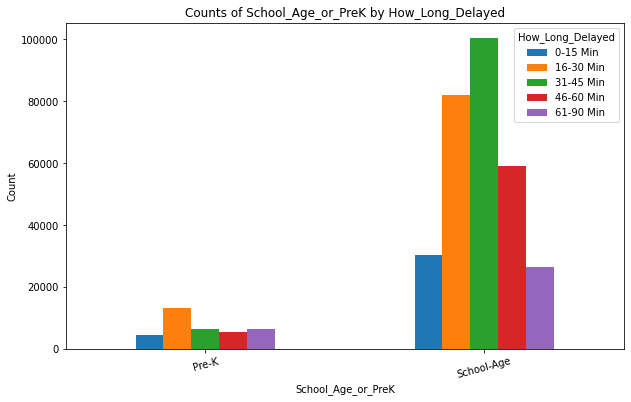

In [9]:
# explore flag columns by group
for item in colname_flag:
    # Filter out rows with None values 
    filtered_df = df.filter(df[item].isNotNull())
    
    filtered_df = filtered_df.filter(filtered_df['How_Long_Delayed'].isin(delay_time_category))
    flag_counts = filtered_df.groupBy(item).count()
    flag_counts.show()
    
    flag_counts = filtered_df.groupBy(item, 'How_Long_Delayed').count().orderBy('How_Long_Delayed')
    flag_counts_pd = flag_counts.toPandas()

    if not flag_counts_pd.empty:
        pivot_df = flag_counts_pd.pivot(index=item, columns='How_Long_Delayed', values='count')
        pivot_df.plot(kind='bar', figsize=(10, 6))
        plt.ylabel('Count')
        plt.xlabel(item)
        plt.xticks(rotation=15)
        plt.title(f'Counts of {item} by How_Long_Delayed')
        plt.show()

In [6]:
# Explore time data
for item in colname_time: 
    filtered_df = df.filter(df[item].isNotNull())
    filtered_df = filtered_df.filter(filtered_df['How_Long_Delayed'].isin(delay_time_category))
    
    time_counts = filtered_df.groupBy(item).count().orderBy('count', ascending=False)
    time_counts.show()

+--------------------+-----+
|         Occurred_On|count|
+--------------------+-----+
|10/20/2022 06:30:...|   64|
|10/14/2022 06:30:...|   61|
|01/31/2019 06:30:...|   53|
|10/12/2022 06:30:...|   53|
|10/17/2022 06:30:...|   51|
|10/19/2022 06:30:...|   51|
|02/25/2019 07:00:...|   50|
|10/28/2022 06:30:...|   49|
|04/25/2022 06:30:...|   48|
|11/01/2022 06:30:...|   47|
|09/30/2022 06:30:...|   46|
|10/06/2022 06:50:...|   45|
|10/31/2022 06:30:...|   45|
|10/11/2022 06:30:...|   44|
|10/04/2022 06:50:...|   44|
|10/18/2022 06:30:...|   44|
|11/14/2022 06:30:...|   42|
|10/03/2022 06:30:...|   41|
|01/05/2022 07:00:...|   41|
|01/31/2022 07:00:...|   40|
+--------------------+-----+
only showing top 20 rows



+--------------------+-----+
|          Created_On|count|
+--------------------+-----+
|09/28/2018 07:46:...|   19|
|10/15/2018 07:46:...|   15|
|01/22/2019 06:32:...|   13|
|10/25/2021 07:48:...|   13|
|10/29/2018 07:18:...|   13|
|10/21/2019 06:59:...|   12|
|03/06/2023 07:41:...|   12|
|03/05/2019 06:27:...|   12|
|09/10/2019 07:32:...|   12|
|03/19/2019 07:32:...|   12|
|01/31/2022 07:11:...|   11|
|05/25/2022 06:39:...|   11|
|09/13/2022 08:02:...|   11|
|11/16/2018 07:52:...|   11|
|02/24/2020 06:45:...|   11|
|03/06/2023 07:38:...|   11|
|02/25/2019 07:46:...|   11|
|09/26/2019 06:53:...|   11|
|11/29/2021 06:58:...|   11|
|11/18/2019 07:47:...|   11|
+--------------------+-----+
only showing top 20 rows



+--------------------+-----+
|         Informed_On|count|
+--------------------+-----+
|09/28/2018 07:46:...|   19|
|10/15/2018 07:46:...|   15|
|01/22/2019 06:32:...|   13|
|10/25/2021 07:48:...|   13|
|10/29/2018 07:18:...|   13|
|10/21/2019 06:59:...|   12|
|03/06/2023 07:41:...|   12|
|03/05/2019 06:27:...|   12|
|09/10/2019 07:32:...|   12|
|03/19/2019 07:32:...|   12|
|01/31/2022 07:11:...|   11|
|05/25/2022 06:39:...|   11|
|09/13/2022 08:02:...|   11|
|11/16/2018 07:52:...|   11|
|02/24/2020 06:45:...|   11|
|03/06/2023 07:38:...|   11|
|02/25/2019 07:46:...|   11|
|09/26/2019 06:53:...|   11|
|11/29/2021 06:58:...|   11|
|11/18/2019 07:47:...|   11|
+--------------------+-----+
only showing top 20 rows



+--------------------+------+
|     Last_Updated_On| count|
+--------------------+------+
|01/01/1900 12:00:...|297846|
|04/26/2019 11:49:...|  2160|
|04/26/2019 11:49:...|  2149|
|12/09/2019 01:56:...|     2|
|05/20/2021 02:06:...|     2|
|02/28/2019 07:18:...|     2|
|01/22/2019 07:59:...|     2|
|01/14/2019 07:04:...|     2|
|11/19/2019 08:02:...|     2|
|01/20/2022 08:11:...|     2|
|04/08/2019 07:52:...|     2|
|11/25/2019 07:11:...|     2|
|09/23/2022 09:37:...|     2|
|02/26/2020 02:15:...|     2|
|10/26/2021 07:55:...|     2|
|03/10/2020 07:50:...|     2|
|01/31/2022 08:05:...|     2|
|10/18/2018 07:34:...|     2|
|01/29/2020 06:38:...|     2|
|11/13/2019 06:58:...|     2|
+--------------------+------+
only showing top 20 rows



In [9]:
# Explore id data
for item in colname_ID: 
    filtered_df = df.filter(df[item].isNotNull())
    filtered_df = filtered_df.filter(filtered_df['How_Long_Delayed'].isin(delay_time_category))
    
    ID_counts = filtered_df.groupBy(item).count().orderBy('count', ascending=False)
    ID_counts.show()

+---------------+-----+
|Busbreakdown_ID|count|
+---------------+-----+
|        1456789|    1|
|        1456815|    1|
|        1456980|    1|
|        1456349|    1|
|        1456523|    1|
|        1458160|    1|
|        1458615|    1|
|        1458692|    1|
|        1458890|    1|
|        1459433|    1|
|        1459628|    1|
|        1460356|    1|
|        1460428|    1|
|        1460520|    1|
|        1460583|    1|
|        1460598|    1|
|        1460653|    1|
|        1461082|    1|
|        1461317|    1|
|        1461525|    1|
+---------------+-----+
only showing top 20 rows



+------+-----+
|Bus_No|count|
+------+-----+
|     0| 1006|
|  1801|  838|
|  1803|  800|
|  1716|  730|
|  1316|  728|
|  1911|  722|
|  1901|  705|
|  1804|  662|
|  1631|  644|
|  1307|  593|
|  1472|  587|
|  1407|  580|
|  1315|  563|
|  9376|  560|
|  1910|  551|
|  1236|  546|
|  1440|  546|
|  1704|  537|
|  1392|  522|
|  1922|  521|
+------+-----+
only showing top 20 rows



+------------+-----+
|Route_Number|count|
+------------+-----+
|           2| 1711|
|           1| 1631|
|           3|  812|
|           5|  611|
|        M965|  478|
|           6|  451|
|        M978|  447|
|        M984|  418|
|        K097|  415|
|           4|  414|
|        M922|  414|
|        M614|  405|
|        M888|  403|
|        M889|  380|
|        N109|  368|
|        M817|  368|
|        M326|  365|
|        M983|  364|
|        M996|  362|
|        M795|  357|
+------------+-----+
only showing top 20 rows



+------------------+-----+
|  Schools_Serviced|count|
+------------------+-----+
|              2930| 2581|
|              2699| 2170|
|              2986| 2029|
|             12084| 1410|
|              2654| 1409|
|              2990| 1290|
|       401,604,839| 1260|
|              S224| 1198|
|26,550,266,702,908| 1161|
|              2909| 1144|
|              C197| 1071|
|             12486| 1063|
|              C042| 1008|
|              2142| 1005|
|       371,003,712|  978|
|       507,905,440|  964|
|30,040,300,503,658|  946|
|             11949|  936|
|             75029|  911|
|              S047|  876|
+------------------+-----+
only showing top 20 rows



+---------------+-----+
|Incident_Number|count|
+---------------+-----+
|     90785769.0|   18|
|     90772175.0|   18|
|     91134233.0|   16|
|     90780268.0|   14|
|     90771245.0|   13|
|     90768543.0|   13|
|     90769335.0|   12|
|     90768180.0|   10|
|     90766409.0|   10|
|     90993263.0|   10|
|     90765758.0|    9|
|     91060298.0|    9|
|     91008593.0|    8|
|     91013846.0|    7|
|     91014787.0|    7|
|     91019590.0|    7|
|     91009765.0|    6|
|     90986700.0|    6|
|     90774662.0|    6|
|    907685047.0|    6|
+---------------+-----+
only showing top 20 rows



In [5]:
# Check for missing data
missing_data = df.selectExpr([f'sum(if({c} is null or {c} = "", 1, 0)) as {c}' for c in df.columns])
missing_data.show()

+-----------+---------------+--------+------+------------+------+----------------+-----------+----------+----+----------------+----------------+-----------------------------+-------------------------------+-------------------------------+--------------------+-----------+---------------+---------------+-------------------------+------------------+
|School_Year|Busbreakdown_ID|Run_Type|Bus_No|Route_Number|Reason|Schools_Serviced|Occurred_On|Created_On|Boro|Bus_Company_Name|How_Long_Delayed|Number_Of_Students_On_The_Bus|Has_Contractor_Notified_Schools|Has_Contractor_Notified_Parents|Have_You_Alerted_OPT|Informed_On|Incident_Number|Last_Updated_On|Breakdown_or_Running_Late|School_Age_or_PreK|
+-----------+---------------+--------+------+------------+------+----------------+-----------+----------+----+----------------+----------------+-----------------------------+-------------------------------+-------------------------------+--------------------+-----------+---------------+---------------

In [14]:
column_name = 'Number_Of_Students_On_The_Bus'
df.select(column_name).describe().show()

# Calculate the mean and standard deviation
mean_std = df.agg(F.mean(column_name).alias('mean'), F.stddev(column_name).alias('std')).collect()[0]
mean = mean_std['mean']
std = mean_std['std']
# Calculate Z-scores for values less than 100
df = df.withColumn('Z_Score', (F.col(column_name) - mean) / std)

filtered_df = df.filter(F.abs(F.col('Z_Score')) < 5)
filtered_df.select(column_name).describe().show()

+-------+-----------------------------+
|summary|Number_Of_Students_On_The_Bus|
+-------+-----------------------------+
|  count|                       360325|
|   mean|           3.0122528273086795|
| stddev|             76.9432968187889|
|    min|                            0|
|    max|                         9658|
+-------+-----------------------------+



+-------+-----------------------------+
|summary|Number_Of_Students_On_The_Bus|
+-------+-----------------------------+
|  count|                       360176|
|   mean|           1.7876288259073343|
| stddev|            4.024851831598487|
|    min|                            0|
|    max|                            9|
+-------+-----------------------------+



In [5]:
# Read supplementary DataFrames
supplement1_df = spark.read.csv("bus-breakdown-and-delays.csv", header=True, inferSchema=True)
supplement2_df = spark.read.csv("bus-breakdown-and-delays2.csv", header=True, inferSchema=True)

# Merge supplementary data
common_columns = list(set(supplement1_df.columns) & set(supplement2_df.columns))
supplement_merged_df = supplement1_df.join(supplement2_df, on=common_columns, how='inner')
print(f"Shape of merged supplementary data: ({supplement_merged_df.count()}, {len(supplement_merged_df.columns)})")


merged_data_df = df.union(supplement_merged_df)
print(f"Shape of merged main data: ({merged_data_df.count()}, {len(merged_data_df.columns)})")

Shape of merged supplementary data: (123760, 21)


Shape of merged main data: (484085, 21)


In [6]:
new_df = merged_data_df.filter(merged_data_df['How_Long_Delayed'].isin(delay_time_category))
new_df = new_df.withColumn("How_Long_Delayed", when(
    col("How_Long_Delayed").isin(delay_time_category) | col("How_Long_Delayed").isNotNull(), 
    col("How_Long_Delayed")).otherwise("91-Inf Min"))
new_df.groupBy("How_Long_Delayed").count().show()

+----------------+------+
|How_Long_Delayed| count|
+----------------+------+
|        0-15 Min| 49947|
|       16-30 Min|136299|
|       31-45 Min|138395|
|       46-60 Min| 79125|
|       61-90 Min| 37506|
+----------------+------+



In [ ]:
df = new_df.toPandas()
df['How_Long_Delayed'].value_counts()
df.dropna(subset=['Run_Type', 'Reason', 'Boro', 'School_Age_or_PreK'], inplace=True)
missing_data = df.isnull().sum()
print(missing_data[missing_data > 0])